In [1]:
import statsmodels
import statsmodels.tsa.arima.model
import scipy
import scipy.stats
import matplotlib.pyplot as plt

## AR(1)

In [2]:
import numpy as np
np.random.seed(12345)
arparams = np.array([.4])
maparams = np.array([])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = statsmodels.tsa.arima_process.arma_generate_sample(ar, ma, 250)
model = statsmodels.tsa.arima.model.ARIMA(y, order=(1, 0, 0)).fit()
model.params

array([-0.04989985,  0.49616834,  0.98459052])

In [3]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -352.937
Date:                Sun, 01 Aug 2021   AIC                            711.875
Time:                        18:12:57   BIC                            722.439
Sample:                             0   HQIC                           716.127
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0499      0.125     -0.400      0.689      -0.294       0.195
ar.L1          0.4962      0.055      9.056      0.000       0.389       0.604
sigma2         0.9846      0.092     10.712      0.000       0.804       1.165
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.96   Prob(JB):                         0.87
Heteroskedasticity (H):               0.91   Skew:                             0.04
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
import numpyro
import jax

numpyro.set_host_device_count(4)

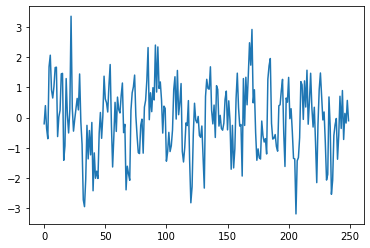

In [5]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y);

In [22]:
def ar1(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    logp = 0
    err = [y[0] - (mu)]
    for t in range(1, len(y)):
        err.append(y[t] - (alpha*y[t-1]))
    
    numpyro.factor(
        'factor',
        numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array(err[1:])),
    )

In [23]:
sampler = numpyro.infer.NUTS(ar1)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y=y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.50      0.06      0.50      0.40      0.58   3741.31      1.00
        mu     -0.03      0.99     -0.03     -1.68      1.57   3555.13      1.00
     sigma      1.00      0.04      1.00      0.93      1.07   3594.76      1.00

Number of divergences: 0


In [39]:
def ar1(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    def scan_fn(log_prob, t):
        err = y[t] - (alpha*y[t-1])
        return (
            log_prob + numpyro.distributions.Normal(0, sigma).log_prob(err),
            None,  # we don't need to collect during scan
        )

    def forward_one_step(prev_log_prob, t):
        err = y[t] - (alpha*y[t-1])
        logp = prev_log_prob + numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array([err]))
        return logp


    
    if False:
        log_prob = 0
        for t in range(1, len(y)):
            log_prob = forward_one_step(
                log_prob, t,
            )
    else:
        log_prob, _ = jax.lax.scan(scan_fn, 0, jax.numpy.array(np.arange(1, len(y))))
        
#         def calc_next(last_y, this_y, err, mu, phi, theta):
#             nu_t = mu + phi * last_y + theta * err
#             return this_y - nu_t

#         err, _ = scan(
#             fn=calc_next,
#             sequences=dict(input=y, taps=[-1, 0]),
#             outputs_info=[err0],
#             non_sequences=[mu, phi, theta],
#         )
    

    
#     logp = 0
#     err = [y[0] - (mu)]
#     for t in range(1, len(y)):
#         err = y[t] - (alpha*y[t-1])
#         logp += numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array([err]))
        
    numpyro.factor(
        'factor',
        log_prob,
    )

In [40]:
sampler = numpyro.infer.NUTS(ar1)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y=y)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/1)>
While tracing the function scan_fn at <ipython-input-39-ef6520bac557>:16 for scan, this concrete value was not available in Python because it depends on the value of the argument 't'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [31]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.50      0.06      0.50      0.40      0.58   3845.90      1.00
        mu     -0.04      0.99     -0.04     -1.68      1.52   3580.67      1.00
     sigma      1.00      0.04      1.00      0.93      1.07   4021.02      1.00

Number of divergences: 0


In [9]:
steps = 10
y_pred = np.ones((4000, len(y)+steps))*np.hstack([y, np.zeros(steps)])

In [10]:
trace = mcmc.get_samples()
for t in range(len(y), len(y)+steps):
    pred = scipy.stats.norm(trace['alpha']*y_pred[:, t-1], trace['sigma']).rvs(len(trace['sigma']))
    y_pred[:, t] = pred

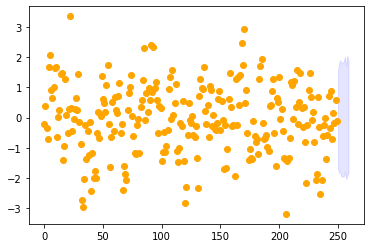

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y, 'o', color='orange');
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');

## ARIMA(1, 0, 1)

In [56]:
import numpy as np
np.random.seed(12345)
arparams = np.array([.4])
maparams = np.array([.7])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = statsmodels.tsa.arima_process.arma_generate_sample(ar, ma, 250, scale=.01)
model = statsmodels.tsa.arima.model.ARIMA(y, order=(1, 0, 1)).fit()
model.params

array([-8.48227904e-04,  5.05502209e-01,  6.80811237e-01,  9.83147853e-05])

In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 797.802
Date:                Sun, 01 Aug 2021   AIC                          -1587.603
Time:                        18:58:54   BIC                          -1573.518
Sample:                             0   HQIC                         -1581.934
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.397      0.691      -0.005       0.003
ar.L1          0.5055      0.059      8.506      0.000       0.389       0.622
ma.L1          0.6808      0.052     13.055      0.000       0.579       0.783
sigma2      9.831e-05   9.15e-06     10.746      0.000    8.04e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.92   Prob(JB):                         0.88
Heteroskedasticity (H):               0.91   Skew:                             0.03
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
def arma(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    logp = 0
    err = [y[0] - (mu + phi*mu)]
    for t in range(1, len(y)):
        err.append(y[t] - (alpha*y[t-1] + phi*err[-1]))
    
    numpyro.factor(
        'factor',
        numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array(err)),
    )

In [59]:
sampler = numpyro.infer.NUTS(arma)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y=y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [60]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.51      0.06      0.51      0.42      0.62   2891.03      1.00
        mu     -0.00      0.00     -0.00     -0.01      0.01   3899.74      1.00
       phi      0.67      0.06      0.67      0.57      0.76   2815.39      1.00
     sigma      0.01      0.00      0.01      0.01      0.01   3414.40      1.00

Number of divergences: 0


In [61]:
steps=10
y_pred = np.ones((4000, len(y)+steps))*np.hstack([y, np.zeros(steps)])

In [67]:
steps = 10
trace = mcmc.get_samples()
for t in range(len(y), len(y)+steps):
    # mu = alpha*y_1 + phi*err_1
    err_1 = y_pred[:, t-1] - (trace['alpha'])
    pred = scipy.stats.norm(
        (
            trace['alpha']*y_pred[:, t-1]
            + trace['phi']*(y_pred[:, t-1]-np.median(y_pred[:, t-1]))
        ),
        trace['sigma']
    ).rvs(len(trace['sigma']))
    y_pred[:, t] = pred

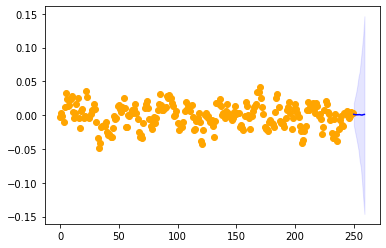

In [68]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y, 'o', color='orange');
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), y_pred[:, -steps:].mean(axis=0), color='blue');

## seasonal arima

Don't know how to generate data, so...let's use the air passengers dataset?

In [121]:
import pandas as pd
df = pd.read_csv('AirPassengers.csv')
y = df['#Passengers'].iloc[:-30].to_numpy()

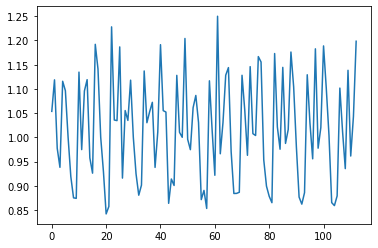

In [122]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(np.arange(len(y)-1), y[1:]/y[:-1]);

In [123]:
from statsmodels.tsa.stattools import pacf, acf

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value enco

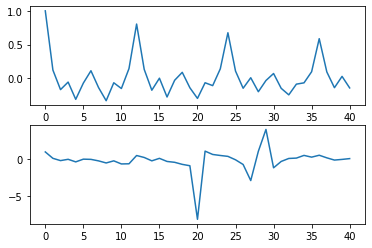

In [124]:
y_diff = y[1:] / y[:-1]
acf_data = acf(y_diff)
pacf_data = pacf(y_diff)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(np.arange(len(acf_data)), acf_data)
ax[1].plot(np.arange(len(pacf_data)), pacf_data)

In [126]:
acf_data

array([ 1.00000000e+00,  1.21566980e-01, -1.68436412e-01, -5.67020592e-02,
       -3.12437108e-01, -7.17858577e-02,  1.11521582e-01, -1.38068918e-01,
       -3.32829338e-01, -6.68550875e-02, -1.51957946e-01,  1.43923523e-01,
        8.04183172e-01,  1.31646463e-01, -1.77194184e-01,  9.41375647e-04,
       -2.77757324e-01, -2.96666485e-02,  8.80371553e-02, -1.40624683e-01,
       -2.98876664e-01, -6.64510595e-02, -1.09171235e-01,  1.40425021e-01,
        6.75272095e-01,  1.06740183e-01, -1.48181648e-01,  7.87679234e-03,
       -1.99561903e-01, -3.31877007e-02,  7.05037558e-02, -1.48963415e-01,
       -2.46011183e-01, -8.70751659e-02, -6.79755059e-02,  9.66446290e-02,
        5.87157961e-01,  9.38460470e-02, -1.39861634e-01,  2.79233904e-02,
       -1.43251747e-01])

In [127]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [105]:
def scale(feat):
    return (feat - np.mean(feat))/np.std(feat)

In [118]:
mod = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
fit = mod.fit()
fit.summary()

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -428.036
Date:                             Sun, 01 Aug 2021   AIC                            864.072
Time:                                     19:14:04   BIC                            874.982
Sample:                                          0   HQIC                           868.499
                                             - 114                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6395      0.348     -1.840      0.066      -1.321       0.042
ma.L1          0.4969      0.383      1.298      0.194      -0.253       1.247
ar.S.L12       0.9508      0.025     37.529      0.000       0.901       1.000
sigma2        89.0067     12.692      7.013      0.000      64.131     113.882
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.33
Prob(Q):                              0.91   Prob(JB):                         0.19
Heteroskedasticity (H):               2.04   Skew:                             0.42
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

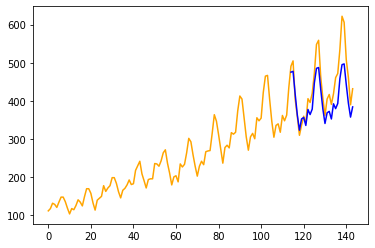

In [119]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['#Passengers'], color='orange')
ax.plot(np.arange(len(df)-30, len(df)), fit.forecast(steps=30), color='blue')

In [128]:
def sarima(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_12 = numpyro.sample(
        'alpha_12',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    logp = 0
    err = [y[0] - (mu + phi*mu)]
    for t in range(13, len(y)):
        err.append(y[t] - (alpha*y[t-1] + alpha_12*y[t-12] - alpha*alpha_12*y[t-13] + phi*err[-1]))
    
    numpyro.factor(
        'factor',
        numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array(err[13:])),
    )

In [129]:
sampler = numpyro.infer.NUTS(sarima)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
y_scaled = scale(y_diff)
mcmc.run(jax.random.PRNGKey(0), y=y_scaled)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [130]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.28      0.40     -0.36     -0.87      0.33   1491.40      1.00
  alpha_12      0.90      0.04      0.90      0.83      0.97   1525.23      1.00
        mu      0.02      1.00      0.02     -1.65      1.66   2772.95      1.00
       phi     -0.02      0.40      0.04     -0.65      0.63   1607.55      1.00
     sigma      0.44      0.04      0.44      0.39      0.50   2436.49      1.00

Number of divergences: 0


In [131]:
y_pred = np.ones((4000, len(y_scaled)+steps))*np.hstack([y_scaled, np.zeros(steps)])

In [132]:
steps = len(df)-len(y)
trace = mcmc.get_samples()
for t in range(len(y_scaled), len(y_scaled)+steps):
    err_1 = y_pred[:, t-1] - (trace['alpha'])
    pred = scipy.stats.norm(
        (
            trace['alpha']*y_pred[:, t-1]
            + trace['alpha_12']*y_pred[:, t-12]
            - trace['alpha_12']*trace['alpha']*y_pred[:, t-13]
            + trace['phi']*(y_pred[:, t-1]-y_pred[:, t-1].mean())
        ),
        trace['sigma']).rvs(len(trace['sigma']),
    )
    y_pred[:, t] = pred

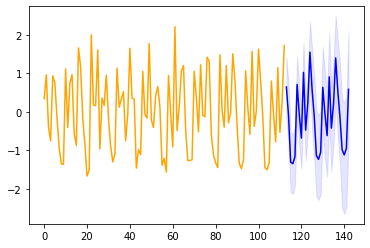

In [133]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y_scaled)), y_scaled, color='orange');
ax.fill_between(np.arange(len(y_scaled), len(y_scaled)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y_scaled), len(y_scaled)+steps), y_pred[:, -steps:].mean(axis=0), color='blue');

In [134]:
y_pred_unscaled = y_pred*np.std(y_diff)+np.mean(y_diff)

In [135]:
restored = [np.ones(4000)*y[0]]
for i in range(y_pred_unscaled.shape[1]):
    restored.append(restored[-1]*y_pred_unscaled[:, i])
restored = np.array(restored).T
restored.shape

(4000, 144)

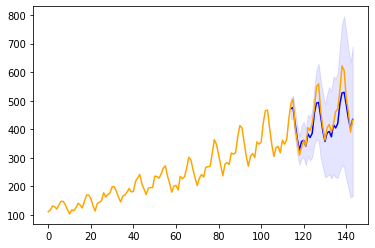

In [136]:
fig, ax = plt.subplots()
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(restored[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), restored[:, -steps:].mean(axis=0), color='blue');
ax.plot(np.arange(len(df)), df['#Passengers'], color='orange');

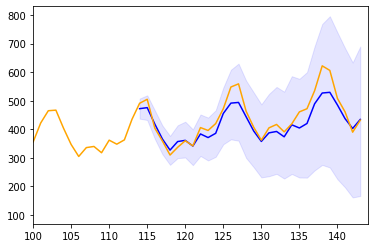

In [137]:
fig, ax = plt.subplots()
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(restored[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), restored[:, -steps:].mean(axis=0), color='blue');
ax.plot(np.arange(len(df)), df['#Passengers'], color='orange');
ax.set_xlim([100, len(df)]);

In [139]:
# hmmm...interesting. not sure, is it growing? yeah, it's growing a bit

restored[:, -30:].mean(axis=0)

array([472.15319845, 475.7842581 , 418.36993384, 365.9857568 ,
       327.20372101, 357.1317954 , 361.3334665 , 341.34799451,
       383.80533332, 371.11543785, 386.01144228, 455.4526017 ,
       491.61409997, 493.98253785, 443.81025683, 393.88492676,
       357.60616614, 387.5594477 , 392.44892078, 373.79069893,
       415.72834394, 404.59972848, 420.39899116, 489.26362921,
       526.96136592, 529.3885984 , 485.20741012, 437.31803733,
       402.93130667, 434.56720848])